# Just Taking from drive to use the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile

# Define the path to your zip file in Google Drive
zip_file_path = '/content/drive/MyDrive/Dataset/cell_images.zip'

# Define the directory where you want to extract the contents
extraction_path = '/content/dataset'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)


In [ ]:
import os

# List the contents of the extracted directory
extracted_files = os.listdir(extraction_path)
print(extracted_files)

['cell_images']


# Modules Imported are shown here:

In [ ]:
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, Lambda, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from glob import glob
import cv2
import os

# Common Functions used in the entire Project:
> These include:
  - Preprocessing of the images
  - Calculation of the model accuracy
  - Output showcase


## Image Preprocessing and Data Preparation

The code you provided demonstrates a process for image preprocessing and data preparation for a machine learning task, such as image classification. The primary goal is to prepare a dataset with preprocessed images and corresponding labels.

## Importing Libraries

```python
import cv2
import numpy as np
import os
```

The code begins by importing necessary libraries:

- `cv2`: OpenCV, a popular computer vision library used for image processing.
- `numpy`: NumPy, a library for numerical computations.
- `os`: Provides functions to interact with the operating system.

## Constants and Categories

```python
IMG_SIZE = 64
category = ['Uninfected', 'Parasitized']
```

- `IMG_SIZE`: The desired size for the images after preprocessing.
- `category`: A list of categories or classes for the images. In this case, 'Uninfected' and 'Parasitized' are two classes for a classification task.

## Image Preprocessing Function

```python
def preprocess_image(image_path):
    # Load the image
    img_array = cv2.imread(image_path, cv2.IMREAD_COLOR)
```

This function, `preprocess_image(image_path)`, performs the following image preprocessing steps:

1. **Load the Image**: It loads the image from the specified `image_path` using OpenCV, and it's read in color mode (`cv2.IMREAD_COLOR`).

```python
    # 1. Noise Removal (Gaussian Blur)
    denoised_image = cv2.GaussianBlur(img_array, (5, 5), 0)
```

2. **Noise Removal**: It applies Gaussian blur to the loaded image to reduce noise.

```python
    # 2. Histogram Equalization (for grayscale images)
    # Convert the image to grayscale (if it's not already)
    gray_image = cv2.cvtColor(denoised_image, cv2.COLOR_BGR2GRAY)
    equalized_image = cv2.equalizeHist(gray_image)
```

3. **Histogram Equalization**: If the image is not already in grayscale, it converts it to grayscale and then performs histogram equalization to enhance the image's contrast.

```python
    # 3. Filtering (e.g., applying a sharpening filter)
    sharpening_filter = np.array([[-1, -1, -1],
                                  [-1, 9, -1],
                                  [-1, -1, -1]])
    filtered_image = cv2.filter2D(equalized_image, -1, sharpening_filter)
```

4. **Filtering**: It applies a sharpening filter to the equalized grayscale image to enhance the image features.

```python
    # Resize the processed image to the desired size
    new_array = cv2.resize(filtered_image, (IMG_SIZE, IMG_SIZE))
    return new_array
```

5. **Resize**: Finally, the preprocessed image is resized to the desired `IMG_SIZE` for consistency.

## Data Preparation Function

```python
def get_train_data_with_preprocess(direct):
    data = []
    for labels in category:
        path = os.path.join(direct, labels)
        class_num = category.index(labels)
        for img in os.listdir(path):
            try:
                processed_image = preprocess_image(os.path.join(path, img))
                data.append([processed_image, class_num])
            except Exception as e:
                print(e)
    return data
```

This function, `get_train_data_with_preprocess(direct)`, prepares the training data. It iterates through the categories ('Uninfected' and 'Parasitized') and for each category:

- It constructs the path to the image files using `os.path.join`.
- It assigns a numeric class identifier (`class_num`) based on the index in the `category` list.
- It processes each image in the category using the `preprocess_image` function.
- The processed image and its class label are appended to the `data` list.

The function returns a list of image data, where each item is a pair of the preprocessed image and its class identifier.

This code provides a foundation for preparing a dataset for a machine learning task, specifically for a binary image classification task involving 'Uninfected' and 'Parasitized' categories.

---


In [ ]:
IMG_SIZE = 64
category = ['Uninfected', 'Parasitized']
def preprocess_image(image_path):

    img_array = cv2.imread(image_path, cv2.IMREAD_COLOR)

    denoised_image = cv2.GaussianBlur(img_array, (5, 5), 0)

    gray_image = cv2.cvtColor(denoised_image, cv2.COLOR_BGR2GRAY)
    equalized_image = cv2.equalizeHist(gray_image)

    sharpening_filter = np.array([[-1, -1, -1],
                                  [-1, 9, -1],
                                  [-1, -1, -1]])
    filtered_image = cv2.filter2D(equalized_image, -1, sharpening_filter)

    new_array = cv2.resize(filtered_image, (IMG_SIZE, IMG_SIZE))

    return new_array

def get_train_data_with_preprocess(direct):
    data = []
    for labels in category:
        path = os.path.join(direct, labels)
        class_num = category.index(labels)
        for img in os.listdir(path):
            try:
                processed_image = preprocess_image(os.path.join(path, img))
                data.append([processed_image, class_num])
            except Exception as e:
                print(e)
    return data

def get_train_data_without_preprocess(direct):
    data = []
    for labels in category:
        path = os.path.join(direct, labels)
        class_num = category.index(labels)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([new_array, class_num])
            except Exception as e:
                print(e)
    return np.array(data)


## The accuracy of the model is calculated by taking out a confusion matrix and the accuracy is calculated from the confusion matrix itself

In [ ]:

def create_confusion_matrix(y_true,y_pred):
  cm = confusion_matrix (y_true,y_pred)
  class_labels = ["Infected", "Parasited"]
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.title("Confusion Matrix")

  plt.show()
  correct_predictions = np.trace(cm)  # Sum of diagonal elements
  total_samples = np.sum(cm)  # Total number of samples

  accuracy = correct_predictions / total_samples
  print("Model's Accuracy is: ",accuracy)

# Basic Preprocessing and EDA of the Dataset:
> Just a Basic overview of the Dataset first of all:
  - The dataset is divided in the following divisions:
    - Thick Smears:
      - Falciparum : Containing 150 infected patients
      - Vivax : Containing 150 infected patients
      - Uninfected: 50 uninfected Patients
    - Thin Smears:
      - Falciparum and uninfected patients: 193 patients
        - 148 infected
        - 45 uninfected even if parasite is present in it
      - Vivax: 171 Infected Patients

In [ ]:
new_data = get_train_data_without_preprocess("dataset/cell_images/")

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



<ipython-input-7-a85384507c34>:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [ ]:
preprocess_data = get_train_data_with_preprocess("dataset/cell_images/")

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/smooth.dispatch.cpp:617: error: (-215:Assertion failed) !_src.empty() in function 'GaussianBlur'

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/smooth.dispatch.cpp:617: error: (-215:Assertion failed) !_src.empty() in function 'GaussianBlur'



> This is to show how our images look like before and after preprocessing the data, we can see clearly that the parasites getting marked and it's more visible when it's done in grayscale images

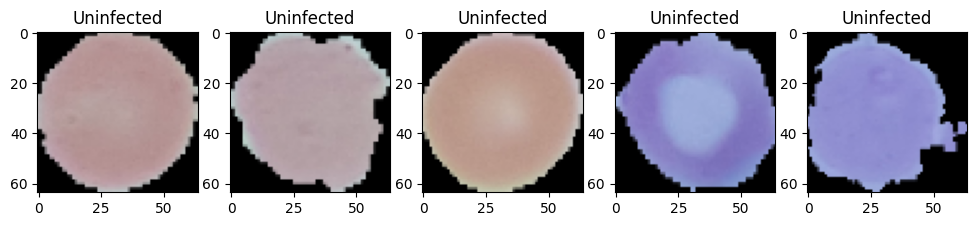

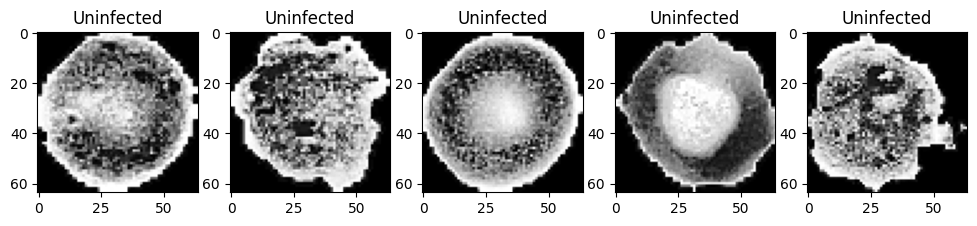

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(new_data[i][0], cmap='gray')
    plt.title(category[new_data[i][1]])
plt.show()
plt.figure(figsize=(12,6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(preprocess_data[i][0], cmap='gray')
    plt.title(category[preprocess_data[i][1]])
plt.show()


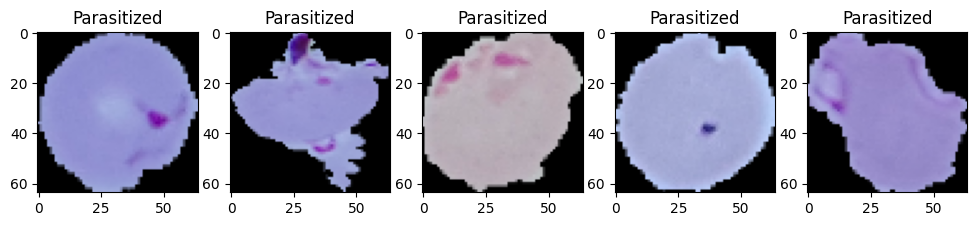

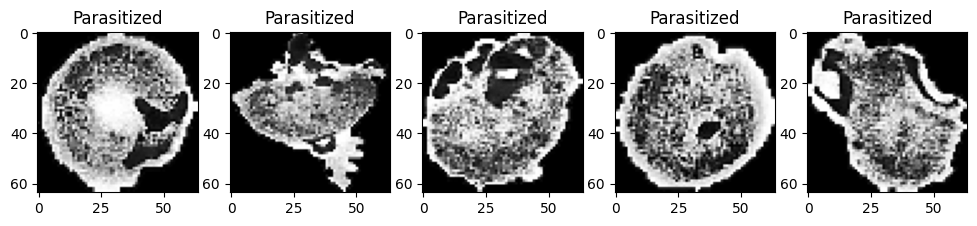

In [ ]:
infected_data_normal = [item for item in new_data if item[1] == category.index('Parasitized')]
infected_data_pre = [item for item in preprocess_data if item[1] == category.index('Parasitized')]
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(infected_data_normal[i][0], cmap='gray')
    plt.title(category[infected_data_normal[i][1]])
plt.show()
plt.figure(figsize=(12,6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(infected_data_pre[i][0], cmap='gray')
    plt.title(category[infected_data_pre[i][1]])
plt.show()

>  Extracing features and Labels from the data after the preprocessing of it

In [ ]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

from tensorflow.keras.utils import to_categorical

y = to_categorical(y, num_classes = 2)

X = np.array(X)
y = np.array(y)

X = X.reshape(-1, 64, 64, 3)

> Test, train and spliting of the dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Data Augmentation and Data Generators for Image Classification

This code demonstrates the setup of data generators for training and testing in a machine learning model, specifically for image classification. It uses the `ImageDataGenerator` class from a deep learning framework like Keras to apply data augmentation techniques to the training data.

## Data Augmentation Configuration for Training Data

```python
train_generator = ImageDataGenerator(
    rescale=1/255,         # Rescale pixel values to the range [0, 1]
    zoom_range=0.3,        # Randomly zoom in on images (up to 30%)
    horizontal_flip=True,  # Randomly flip images horizontally
    rotation_range=30      # Randomly rotate images up to 30 degrees
)
```

In this section, you configure an `ImageDataGenerator` for the training data. The key data augmentation techniques applied are:

- **Rescaling**: The pixel values of the images are rescaled to the range [0, 1], which helps in standardizing the data and can improve training stability.

- **Zooming**: Images are randomly zoomed in, with a maximum zoom factor of 30%. This introduces diversity into the training data and helps the model become more robust to different scales of objects.

- **Horizontal Flipping**: Images are randomly flipped horizontally. This helps the model learn to recognize objects from different perspectives, which is particularly useful for tasks where object orientation varies.

- **Rotation**: Images are randomly rotated by up to 30 degrees. Rotation augmentation allows the model to learn features from differently oriented objects, making it more invariant to rotations in real-world data.

## Data Generator for Training Data

```python
train_generator = train_generator.flow(
    np.array(X_train),  # Training images
    y_train,           # Training labels
    batch_size=64,      # Batch size for training
    shuffle=False       # Don't shuffle the data
)
```

This code uses the configured `ImageDataGenerator` to create a generator for the training data. It loads the training images from `X_train` and their corresponding labels from `y_train`. The `batch_size` determines how many images are processed at once during training, and `shuffle` is set to `False` to maintain the order of the training data.

## Data Generator for Test Data

```python
test_generator = ImageDataGenerator(rescale=1/255)
test_generator = test_generator.flow(
    np.array(X_test),  # Test images
    y_test,           # Test labels
    batch_size=64,    # Batch size for testing
    shuffle=False     # Don't shuffle the data
)
```

A similar generator is set up for the test data, but without data augmentation techniques. Test data is usually not augmented because the evaluation should reflect the model's performance on the original, unaltered data.

### Our reason for Data Augmentation

To increase the variety of training data by applying random transformations, such as rotations, flips and zooms. This helps our CNN and VGG19 Model generalize better to more unseen data and reduses the risk of overfitting by exposing the model to a wider range of data variations

In [ ]:
train_generator = ImageDataGenerator(rescale = 1/255,
                                     zoom_range = 0.3,
                                     horizontal_flip = True,
                                     rotation_range = 30)

test_generator = ImageDataGenerator(rescale = 1/255)

train_generator = train_generator.flow(np.array(X_train),
                                       y_train,
                                       batch_size = 64,
                                       shuffle = False)

test_generator = test_generator.flow(np.array(X_test),
                                     y_test,
                                     batch_size = 64,
                                     shuffle = False)

# VGG19-Based Image Classification Model

This code builds an image classification model using the VGG19 architecture. It loads a pre-trained VGG19 model with "imagenet" weights, fine-tunes it for a specific classification task, and compiles the model for training.

- **Loading Pre-trained Model**: A VGG19 model is loaded with pre-trained weights, excluding the fully connected layers.

- **Freezing Pre-trained Layers**: All layers in the VGG19 model are set to non-trainable, except for custom layers added later.

- **Custom Layers**: A `Flatten` layer and a `Dense` layer with softmax activation are added for the classification task.

- **Creating the Final Model**: A new model is created by specifying input and output layers.

- **Model Compilation**: The model is compiled with categorical cross-entropy loss, accuracy metric, and the Adam optimizer.

This code sets up a VGG19-based image classification model ready for training on the infected and non-infected blood smear images

In [ ]:
vg19 = VGG19(input_shape=[IMG_SIZE, IMG_SIZE] + [3], weights="imagenet", include_top=False)

for layer in vg19.layers:
    layer.trainable = False

x = Flatten()(vg19.output)
prediction = Dense(len(category), activation="softmax")(x)
model = Model(inputs=vg19.input, outputs=prediction)


model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

80134624/80134624 [==============================] - 0s 0us/step


## Model Training with fit_generator

This code trains the previously defined image classification model using the `fit_generator` method. The training process is configured as follows:

- **Training Data Generator**: `train_generator` is used as the data generator for training.

- **Steps per Epoch**: The number of training steps per epoch is calculated as the total number of training samples divided by the batch size (64).

- **Number of Epochs**: The model is trained for 50 epochs.

- **Shuffling Data**: Training data is not shuffled during each epoch (`shuffle = False`).

- **Validation Data Generator**: The `test_generator` is used for validation during training.

- **Validation Steps**: The number of validation steps is determined by the length of the `test_generator`.

The training history, including loss and accuracy, is stored in the `history` variable.


In [ ]:
history = model.fit_generator(train_generator,
                                   steps_per_epoch = len(X_train)/64,
                                   epochs = 50,
                                   shuffle = False,
                                   validation_data=test_generator, validation_steps=len(test_generator))

Epoch 1/50


<ipython-input-19-a89e9b5015f9>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


301/301 [==============================] - 44s 116ms/step - loss: 0.4089 - accuracy: 0.8215 - val_loss: 0.3278 - val_accuracy: 0.8569
Epoch 2/50
301/301 [==============================] - 36s 119ms/step - loss: 0.3186 - accuracy: 0.8711 - val_loss: 0.3221 - val_accuracy: 0.8564
Epoch 3/50
301/301 [==============================] - 44s 147ms/step - loss: 0.3026 - accuracy: 0.8760 - val_loss: 0.2865 - val_accuracy: 0.8769
Epoch 4/50
301/301 [==============================] - 34s 113ms/step - loss: 0.2970 - accuracy: 0.8803 - val_loss: 0.2691 - val_accuracy: 0.8858
Epoch 5/50
301/301 [==============================] - 34s 114ms/step - loss: 0.2931 - accuracy: 0.8822 - val_loss: 0.2532 - val_accuracy: 0.8979
Epoch 6/50
301/301 [==============================] - 34s 112ms/step - loss: 0.2891 - accuracy: 0.8874 - val_loss: 0.2445 - val_accuracy: 0.9005
Epoch 7/50
301/301 [==============================] - 35s 116ms/step - loss: 0.2778 - accuracy: 0.8892 - val_loss: 0.2656 - val_accuracy: 0.8

> Evaluation of the model:

In [ ]:
model.evaluate_generator(test_generator)

<ipython-input-20-faa0e9406f88>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_generator)


[0.21980851888656616, 0.9140058159828186]

## Visualization of the accuracies and the losses while training the model

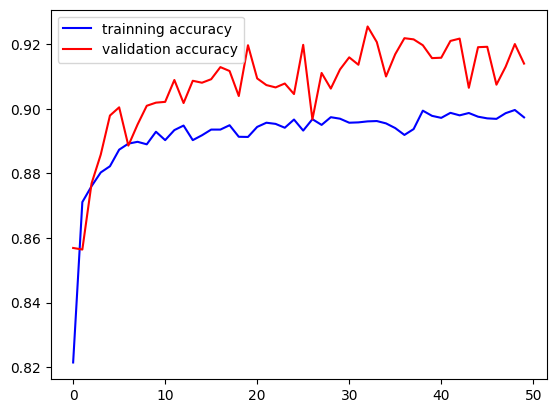

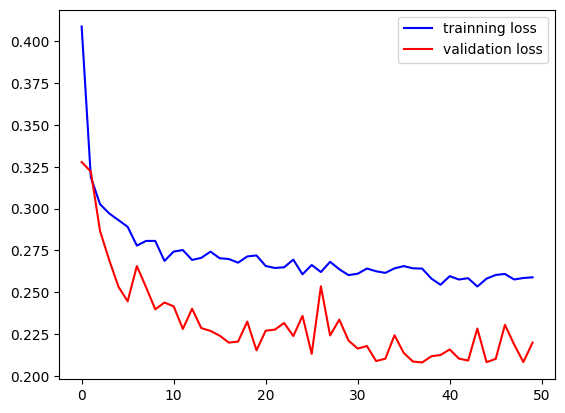

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(test_generator)
y_pred

130/130 [==============================] - 4s 30ms/step


array([[8.2021797e-01, 1.7978199e-01],
       [9.0342820e-01, 9.6571788e-02],
       [2.2688853e-06, 9.9999774e-01],
       ...,
       [5.2054033e-02, 9.4794595e-01],
       [5.0165105e-01, 4.9834892e-01],
       [9.4544083e-01, 5.4559235e-02]], dtype=float32)

In [ ]:
y_pred = np.argmax(y_pred, axis=1)
y_pred
y_true = np.argmax(y_test,axis=1)

##  Final Accuracy of our VGG-19 Model

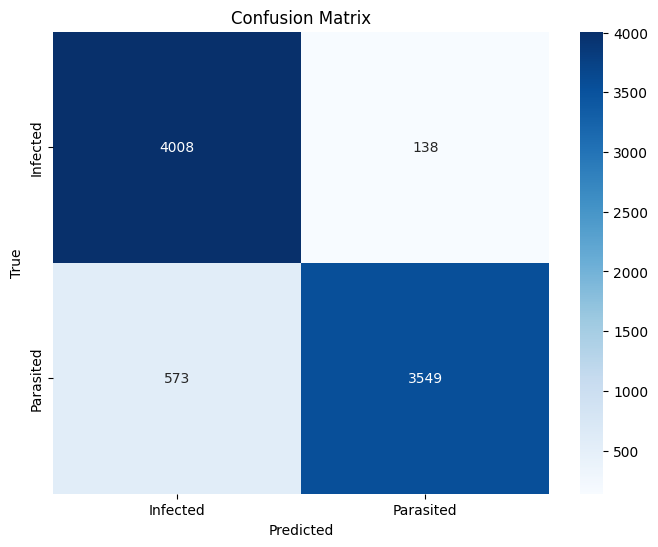

Model's Accuracy is:  0.9140058055152395


In [ ]:
create_confusion_matrix(y_true,y_pred)

In [ ]:
model.save("vgg_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import tensorflow as tf
category = ['Uninfected', 'Parasitized']
def prepare(filepath):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

model1  = tf.keras.models.load_model("vgg_model.h5")

# Convolutional Neural Network (CNN) Architecture

This code defines a Convolutional Neural Network (CNN) for an image classification task. The CNN architecture is as follows:

- **Input Shape**: Images are expected to have dimensions of 64x64 pixels with 3 color channels (RGB).

- **Convolutional Layers**: Three sets of convolutional layers are used with increasing filter sizes (16, 32, 64). Each convolutional layer applies a 2x2 kernel and uses the ReLU activation function.

- **Max Pooling Layers**: After each set of convolutional layers, a max-pooling layer with a 2x2 pooling size is applied. Max pooling reduces the spatial dimensions of the feature maps.

- **Flatten Layer**: Following the convolutional and pooling layers, a flatten layer is used to convert the 2D feature maps into a 1D vector.

- **Dense Layers**: Two dense (fully connected) layers are added. The first dense layer has 500 units with ReLU activation, serving as a hidden layer for feature extraction. The second dense layer has 2 units with softmax activation, making it suitable for binary classification.

- **Model Summary**: The model architecture is summarized, displaying layer types, output shapes, and the number of parameters.

This CNN architecture is designed for image classification tasks, particularly for binary classification, and can be trained on image data with the specified dimensions.



In [ ]:
### Create Model from scratch using CNN
model=Sequential()
model.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(64,64,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation ="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dense(500,activation="relu"))
model.add(Dense(2,activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        208       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 64)          0

## Model Compilation

This code compiles a neural network model with the following settings:

- **Loss Function**: Categorical cross-entropy loss is used, suitable for multi-class classification tasks.

- **Optimizer**: The Adam optimizer is selected for optimizing the model's weights. Adam is an efficient and widely used optimization algorithm.

- **Metrics**: The model's performance is monitored using accuracy, which measures the proportion of correctly classified samples during training.

The compilation step configures the model for training and specifies how it should learn from the data.


In [ ]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

## Model Training with fit_generator

This code trains a neural network model using the `fit_generator` method with the following settings:

- **Training Data Generator**: `train_generator` is used as the data generator for training the model.

- **Validation Data Generator**: `test_generator` is used for validation during training.

- **Number of Epochs**: The model is trained for 50 epochs, which represents the number of complete passes through the training dataset.

- **Steps per Epoch**: The number of training steps per epoch is determined by the length of the `train_generator`.

- **Validation Steps**: The number of validation steps is determined by the length of the `test_generator`.

In [ ]:
r = model.fit_generator(
  train_generator,
  validation_data=test_generator,
  epochs=50,
  steps_per_epoch=len(train_generator),
  validation_steps=len(test_generator)
)

Epoch 1/50


<ipython-input-37-4237d3c723df>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


302/302 [==============================] - 32s 94ms/step - loss: 0.4758 - accuracy: 0.7663 - val_loss: 0.1954 - val_accuracy: 0.9320
Epoch 2/50
302/302 [==============================] - 27s 89ms/step - loss: 0.2199 - accuracy: 0.9242 - val_loss: 0.1657 - val_accuracy: 0.9439
Epoch 3/50
302/302 [==============================] - 28s 92ms/step - loss: 0.1864 - accuracy: 0.9421 - val_loss: 0.1685 - val_accuracy: 0.9474
Epoch 4/50
302/302 [==============================] - 27s 90ms/step - loss: 0.1753 - accuracy: 0.9452 - val_loss: 0.1398 - val_accuracy: 0.9526
Epoch 5/50
302/302 [==============================] - 28s 94ms/step - loss: 0.1684 - accuracy: 0.9453 - val_loss: 0.1333 - val_accuracy: 0.9567
Epoch 6/50
302/302 [==============================] - 28s 93ms/step - loss: 0.1642 - accuracy: 0.9477 - val_loss: 0.1396 - val_accuracy: 0.9560
Epoch 7/50
302/302 [==============================] - 30s 98ms/step - loss: 0.1562 - accuracy: 0.9499 - val_loss: 0.1287 - val_accuracy: 0.9573
Epo

## plotting of the losses and accuracies noted while training the model :

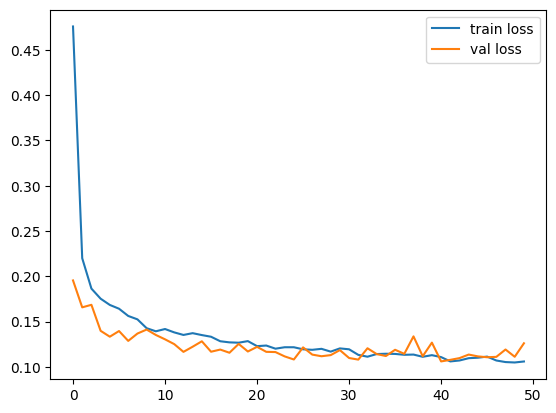

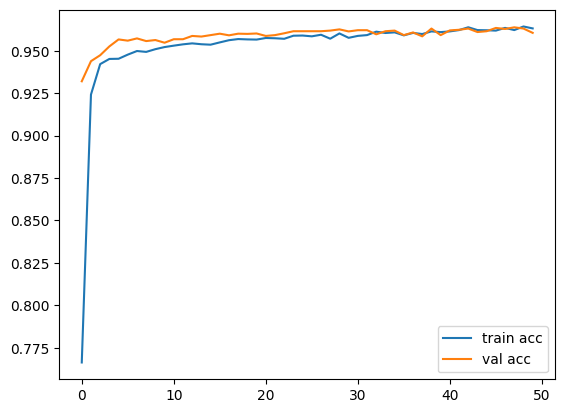

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
model.save("CNN_model.h5")

In [ ]:
y_pred = model.predict(test_generator)

130/130 [==============================] - 1s 8ms/step


In [ ]:
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test,axis=1)

## Final Accuracy of our model :

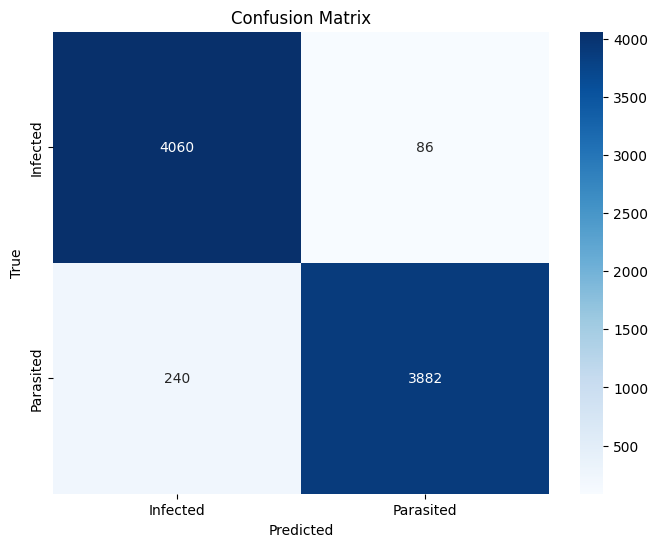

Model's Accuracy is:  0.9605708756652153


In [ ]:
x = create_confusion_matrix(y_true, y_pred)

# Final Outcome of our model:

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

model=load_model('vgg_model.h5')

img=image.load_img('test_image.png',target_size=(64,64))

In [ ]:
x=image.img_to_array(img)
x=x/255

In [ ]:
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 64, 64, 3)

In [ ]:
model.predict(img_data)

1/1 [==============================] - 1s 1s/step


array([[1., 0.]], dtype=float32)

In [ ]:
a=np.argmax(model.predict(img_data), axis=1)

1/1 [==============================] - 0s 28ms/step


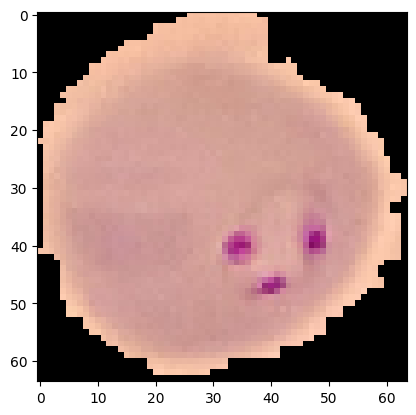

It is Infected


In [ ]:
plt.imshow(img)
plt.show()
if(a==1):
    print("It is Uninfected")
else:
    img
    print("It is Infected")